In [1]:
#Import all the necessary libraries
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

#### Data pre-processing

In [2]:
# Load the data
data = pd.read_csv('portfolio_data.txt', header=None, delim_whitespace=True, skiprows=21)

# Display basic information and the first few rows of the dataset
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,35.79,30.11,31.59,21.73,30.18,22.30,20.40,86.77,20.05,24.40,18.75,64.28,20.10,14.84,23.11,15.44,14.94,37.08,18.78,1.00000
1,36.10,30.20,31.91,22.56,30.04,22.78,20.80,86.81,20.49,24.97,18.77,65.50,20.60,14.83,23.60,15.67,15.46,36.87,19.32,1.00004
2,36.16,30.15,32.11,22.31,30.38,23.04,20.85,86.30,20.58,24.96,18.69,65.30,20.67,14.81,23.37,15.86,15.50,37.17,19.64,1.00008
3,36.27,30.08,31.35,22.33,30.82,23.50,21.20,88.11,20.22,25.79,18.57,64.18,20.65,14.86,24.03,15.80,15.66,36.66,19.68,1.00012
4,36.16,30.09,31.38,22.77,30.96,24.22,21.51,88.22,21.37,25.98,18.66,63.75,20.62,15.01,25.41,15.66,15.95,35.76,19.98,1.00016


#### Data split

In [3]:
# Split the data into training and test sets
R_train = data.iloc[:2000]
R_test = data.iloc[2000:]

# Display the shapes of the train and test datasets to verify the split
print("Dimensions of train dataset: ", R_train.shape)
print("Dimensions of test dataset: ", R_test.shape, "\n")

Dimensions of train dataset:  (2000, 20)
Dimensions of test dataset:  (517, 20) 



#### Portfolio Optimization

In [4]:
# Calculate the covariance matrix for the risky assets
cov_matrix = R_train.iloc[:, :19].cov()

# Calculate the mean returns for the risky assets
mean_returns = R_train.iloc[:, :19].mean()

# Convert daily prices to daily returns
R_train_returns = R_train.pct_change().dropna()
R_test_returns = R_test.pct_change().dropna()

# Annualized target returns
annual_targets = [0.1, 0.2, 0.4]

# Function to annualize daily returns
def annualize_return(daily_returns):
    return np.sum(daily_returns) * 250

# Function to calculate portfolio variance
def portfolio_variance(weights, returns):
    return np.dot(weights.T, np.dot(returns.cov() * 250, weights))

# Optimization function
def optimize_portfolio(target_return, returns):
    # Number of assets
    n_assets = returns.shape[1]
    
    # Initial guess for weights
    initial_weights = np.array([1/n_assets] * n_assets)
    
    # Constraints: sum of weights = 1, achieve target annual return
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: annualize_return(np.dot(returns.mean(), x)) - target_return})
    
    # Bounds for each weight (-1, 1) allowing short selling
    bounds = [(-1, 1) for _ in range(n_assets)]
    
    # Minimize the portfolio variance
    result = minimize(portfolio_variance, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

# Apply optimization for each target return
optimized_portfolios = {f"{int(target*100)}%": optimize_portfolio(target, R_train_returns) for target in annual_targets}

#### Cumulative portfolio value

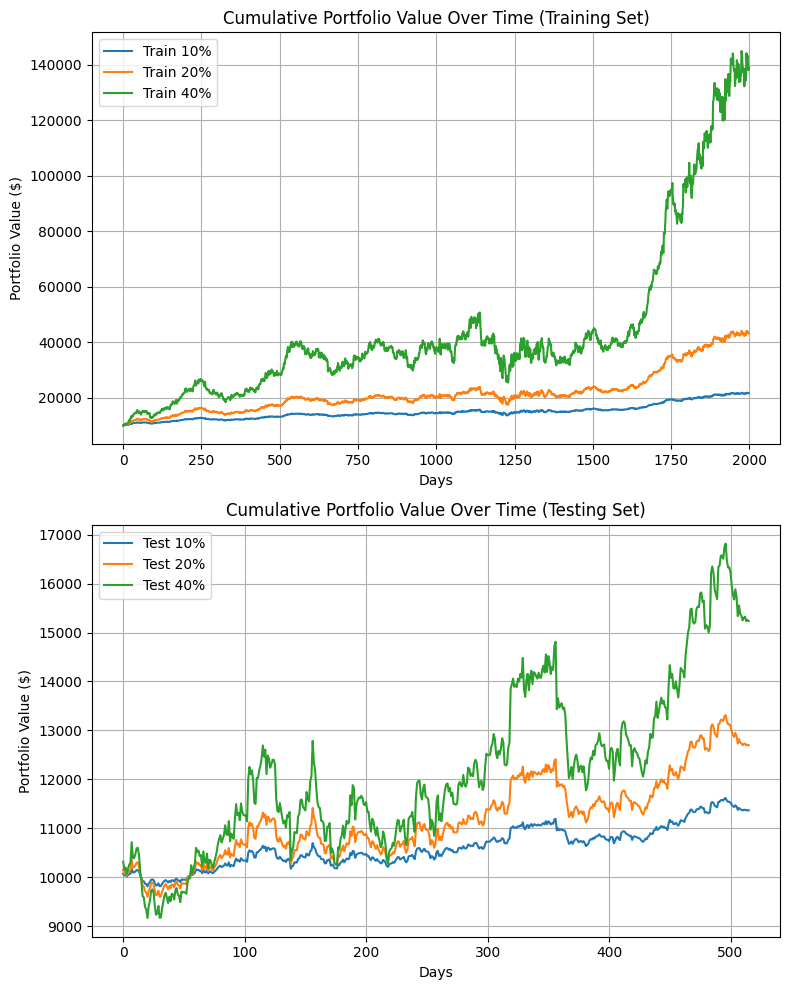

In [5]:
# Function to calculate cumulative portfolio value over time
def cumulative_portfolio_value(initial_investment, returns, weights):
    portfolio_returns = np.dot(returns, weights)
    cumulative_returns = np.cumprod(1 + portfolio_returns)
    return initial_investment * cumulative_returns

# Initial investment
initial_investment = 10000

# Correct the issue by ensuring the correct use of target returns in labeling
cumulative_values_train = {f"{int(target*100)}%": cumulative_portfolio_value(initial_investment, R_train_returns, optimized_portfolios[f"{int(target*100)}%"].x)
                           for target in annual_targets}

cumulative_values_test = {f"{int(target*100)}%": cumulative_portfolio_value(initial_investment, R_test_returns, optimized_portfolios[f"{int(target*100)}%"].x)
                          for target in annual_targets}

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=False)

for key in cumulative_values_train.keys():
    ax[0].plot(cumulative_values_train[key], label=f'Train {key}')
    ax[1].plot(cumulative_values_test[key], label=f'Test {key}')

ax[0].set_title('Cumulative Portfolio Value Over Time (Training Set)')
ax[1].set_title('Cumulative Portfolio Value Over Time (Testing Set)')
for a in ax:
    a.set_xlabel('Days')
    a.set_ylabel('Portfolio Value ($)')
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

#### Annual Return, Risk, Min.-Max. Allocation and Leverage

In [6]:
# Extract optimization results
optimization_results = {key: {'Weights': result.x, 'Variance': portfolio_variance(result.x, R_train_returns)} for key, result in optimized_portfolios.items()}

# Calculate annualized return and risk for each portfolio
annualized_results = {
    key: {
        'Annualized Return': annualize_return(np.dot(R_train_returns.mean(), result['Weights'])),
        'Annualized Risk': np.sqrt(portfolio_variance(result['Weights'], R_train_returns))  # Standard deviation
    }
    for key, result in optimization_results.items()
}

annualized_results

{'10%': {'Annualized Return': 0.10000000000191876,
  'Annualized Risk': 0.08679412571640518},
 '20%': {'Annualized Return': 0.20000000000056706,
  'Annualized Risk': 0.18321833707577714},
 '40%': {'Annualized Return': 0.40000000000118685,
  'Annualized Risk': 0.3760782875365875}}

In [7]:
leverage = {key: np.sum(np.abs(result['Weights'])) for key, result in optimization_results.items()}

leverage

{'10%': 1.9740060114597993, '20%': 3.05219573913915, '40%': 5.5130552977006015}

In [8]:
# Determine the asset with minimum and maximum allocations for each portfolio
asset_allocation_details = {
    key: {
        'Max Allocation Asset': np.argmax(result['Weights']),
        'Max Allocation Value': np.max(result['Weights']),
        'Min Allocation Asset': np.argmin(result['Weights']),
        'Min Allocation Value': np.min(result['Weights'])
    }
    for key, result in optimization_results.items()
}

asset_allocation_details

{'10%': {'Max Allocation Asset': 19,
  'Max Allocation Value': 0.7335166934894055,
  'Min Allocation Asset': 5,
  'Min Allocation Value': -0.13440588024294803},
 '20%': {'Max Allocation Asset': 19,
  'Max Allocation Value': 0.43742670870213596,
  'Min Allocation Asset': 5,
  'Min Allocation Value': -0.28580374349370713},
 '40%': {'Max Allocation Asset': 13,
  'Max Allocation Value': 0.708640222868767,
  'Min Allocation Asset': 5,
  'Min Allocation Value': -0.5867546151098472}}

#### Additional Challenge

In [9]:
data = pd.read_csv('portfolio_data.txt', header=None, delim_whitespace=True, skiprows=21)

industry_mapping = {
    0: 'Financial Services',
    1: 'Financial Services',
    2: 'Energy',
    3: 'Technology',
    4: 'Retail',
    5: 'Technology',
    6: 'Entertainment',
    7: 'Financial Services',
    8: 'Technology',
    9: 'Technology',
    10: 'Consumer Goods',
    11: 'Industrial',
    12: 'Technology',
    13: 'Consumer Goods',
    14: 'Technology',
    15: 'Consumer Services',
    16: 'Telecommunications',
    17: 'Retail',
    18: 'Telecommunications',
    19: 'Currency'
}

max_industry_exposure = {
    'Financial Services': 0.25,
    'Energy': 0.15,
    'Technology': 0.20,
    'Retail': 0.10,
    'Entertainment': 0.05,
    'Consumer Goods': 0.10,
    'Industrial': 0.10,
    'Consumer Services': 0.05,
    'Telecommunications': 0.10,
    'Currency': 0.05  
}

# Rename the columns
data = data.rename(columns=industry_mapping)

# Split the data into training and test sets
R_train = data.iloc[:2000]
R_test = data.iloc[2000:]

# Calculate the covariance matrix for the risky assets
cov_matrix = R_train.iloc[:, :19].cov()

# Calculate the mean returns for the risky assets
mean_returns = R_train.iloc[:, :19].mean()

# Convert daily prices to daily returns
R_train_returns = R_train.pct_change().dropna()
R_test_returns = R_test.pct_change().dropna()

In [24]:
# Annualized target returns
annual_targets = [0.1, 0.2, 0.4]

# Function to annualize daily returns
def annualize_return(daily_returns):
    return np.sum(daily_returns) * 250

# Function to calculate portfolio variance
def portfolio_variance(weights, returns):
    return np.dot(weights.T, np.dot(returns.cov() * 250, weights))

def transaction_costs(initial_weights, new_weights, trade_cost_percent):
    # Calculate the absolute change in weights
    trade_amounts = np.abs(new_weights - initial_weights)
    # Total costs are the trade amounts times the trade cost percentage
    return np.sum(trade_amounts * trade_cost_percent)

def optimize_portfolio(target_return, returns, max_weight_per_asset=0.1, max_industry_exposure=max_industry_exposure):
    n_assets = returns.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)

    # Assume a fixed transaction cost rate of 0.005 (0.5% of the trade)
    trade_cost_percent = 0.005
    # Assume maximum allowable transaction costs as 1% of the portfolio
    max_transaction_cost = 0.01

    
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda x: annualize_return(np.dot(returns.mean(), x)) - target_return},  # Achieve target return
        {'type': 'ineq', 'fun': lambda x: max_transaction_cost - transaction_costs(initial_weights, x, trade_cost_percent)}
    )
    
    # Generating a constraint for each asset so that no weight exceeds max_weight_per_asset
    asset_constraints = [{'type': 'ineq', 'fun': lambda x, i=i: max_weight_per_asset - x[i]} for i in range(n_assets)]

    # Inequality constraints for industry exposure
    industry_constraints = []
    industries = returns.columns.unique()  # Assuming industries are at the top level of MultiIndex columns
    for industry in industries:
        industry_indices = [i for i, col in enumerate(returns.columns) if col[0] == industry]
        industry_constraints.append(
            {'type': 'ineq', 'fun': lambda x, indices=industry_indices: max_industry_exposure[industry] - sum(x[i] for i in indices)}
        )
    
    # Add asset-specific constraints to the main constraints tuple
    constraints = constraints + tuple(asset_constraints) + tuple(industry_constraints)

    # Bounds for each weight (-1, 1) allowing short selling
    bounds = [(-1, 1) for _ in range(n_assets)]

    # Minimize the portfolio variance
    result = minimize(portfolio_variance, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Apply optimization for each target return
optimized_portfolios = {f"{int(target*100)}%": optimize_portfolio(target, R_train_returns, max_weight_per_asset=0.2, max_industry_exposure=max_industry_exposure) for target in annual_targets}

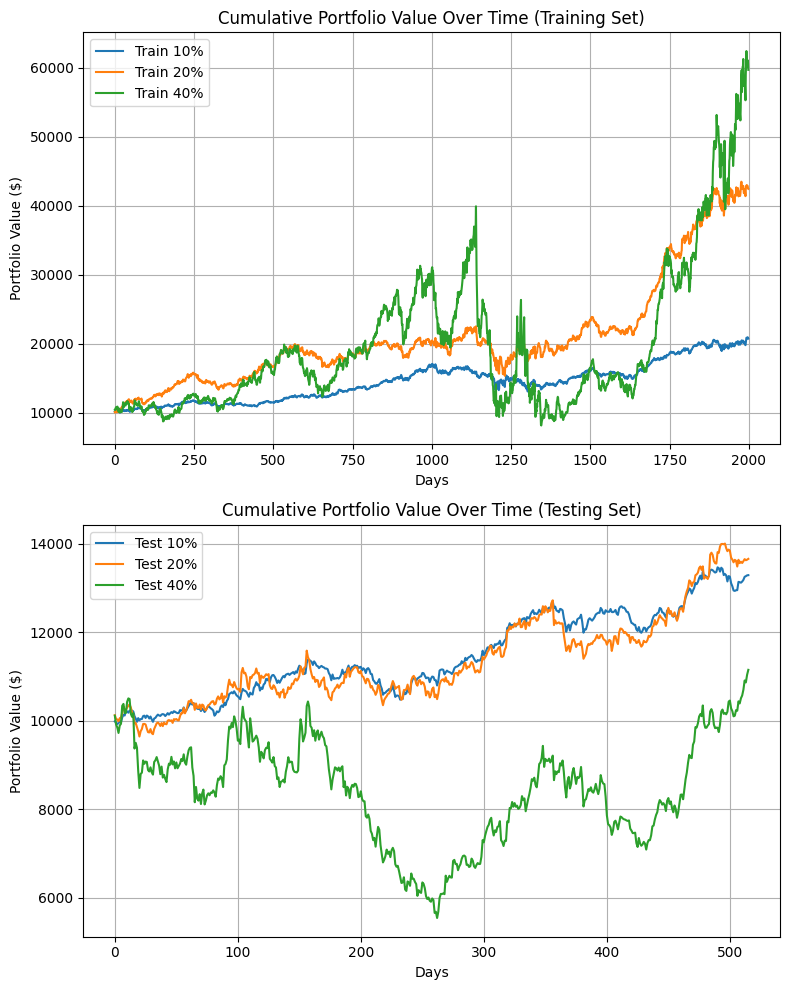

In [26]:
# Function to calculate cumulative portfolio value over time
def cumulative_portfolio_value(initial_investment, returns, weights):
    portfolio_returns = np.dot(returns, weights)
    cumulative_returns = np.cumprod(1 + portfolio_returns)
    return initial_investment * cumulative_returns

# Initial investment
initial_investment = 10000

# Correct the issue by ensuring the correct use of target returns in labeling
cumulative_values_train = {f"{int(target*100)}%": cumulative_portfolio_value(initial_investment, R_train_returns, optimized_portfolios[f"{int(target*100)}%"].x)
                           for target in annual_targets}

cumulative_values_test = {f"{int(target*100)}%": cumulative_portfolio_value(initial_investment, R_test_returns, optimized_portfolios[f"{int(target*100)}%"].x)
                          for target in annual_targets}

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=False)

for key in cumulative_values_train.keys():
    ax[0].plot(cumulative_values_train[key], label=f'Train {key}')
    ax[1].plot(cumulative_values_test[key], label=f'Test {key}')

ax[0].set_title('Cumulative Portfolio Value Over Time (Training Set)')
ax[1].set_title('Cumulative Portfolio Value Over Time (Testing Set)')
for a in ax:
    a.set_xlabel('Days')
    a.set_ylabel('Portfolio Value ($)')
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

In [27]:
# Extract optimization results
optimization_results = {key: {'Weights': result.x, 'Variance': portfolio_variance(result.x, R_train_returns)} for key, result in optimized_portfolios.items()}

# Calculate annualized return and risk for each portfolio
annualized_results = {
    key: {
        'Annualized Return': annualize_return(np.dot(R_train_returns.mean(), result['Weights'])),
        'Annualized Risk': np.sqrt(portfolio_variance(result['Weights'], R_train_returns))  # Standard deviation
    }
    for key, result in optimization_results.items()
}

annualized_results

{'10%': {'Annualized Return': 0.10000000000138236,
  'Annualized Risk': 0.1337178171022855},
 '20%': {'Annualized Return': 0.20000000000087922,
  'Annualized Risk': 0.19604392800815312},
 '40%': {'Annualized Return': 0.37845408572691164,
  'Annualized Risk': 0.5555284974509016}}

In [28]:
leverage = {key: np.sum(np.abs(result['Weights'])) for key, result in optimization_results.items()}
leverage

{'10%': 1.583944556491763, '20%': 2.5011083317302303, '40%': 5.800000000000292}

In [32]:
# Determine the asset with minimum and maximum allocations for each portfolio
asset_allocation_details = {
    key: {
        'Max Allocation Asset': np.argmax(result['Weights']),
        'Max Allocation Value': np.max(result['Weights']),
        'Min Allocation Asset': np.argmin(result['Weights']),
        'Min Allocation Value': np.min(result['Weights']),
    }
    for key, result in optimization_results.items()
}

asset_allocation_details

{'10%': {'Max Allocation Asset': 4,
  'Max Allocation Value': 0.2,
  'Min Allocation Asset': 17,
  'Min Allocation Value': -0.07168160202658046},
 '20%': {'Max Allocation Asset': 4,
  'Max Allocation Value': 0.2,
  'Min Allocation Asset': 5,
  'Min Allocation Value': -0.3015910218905166},
 '40%': {'Max Allocation Asset': 2,
  'Max Allocation Value': 0.20000000000024018,
  'Min Allocation Asset': 1,
  'Min Allocation Value': -1.0}}